In [2]:
import pandas as pd
import numpy as np
import pathlib
import pickle
import torch as t
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
from statistics import mean, median
sys.path.append('C:\\Users\\keren\\Projects\\pytorch-sgns')
from models import ai2v_model
from sklearn.manifold import TSNE
import codecs
import csv
import os
from random import randrange
import datetime
import time

In [12]:
H_FOLD = 'C:/Users/keren/Projects/pytorch-sgns'
DATASET = 'movielens'

DATA_FOLD = f'corpus/{DATASET}_llo'

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
I2V_OUT_FOLD = f'output/{DATASET}_i2v_llo'
BPR_OUT_FOLD = f'output/{DATASET}_bpr_llo'
LGCN_OUT_FOLD = f'output/{DATASET}_lightgcn_llo'
NCF_OUT_FOLD = f'output/{DATASET}_ncf_llo'

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'
I2V_MODEL_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/model.pt'

## Performance on cold start items

In [3]:
ic = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'ic.dat').open('rb'))
idx2item = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'idx2item.dat').open('rb'))

In [55]:
k = 20
metric = 'hr'

In [56]:
# AI2V_MET_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/ai2v_netflix_{k}_{metric}.csv'
# I2V_MET_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/i2v_netflix_{k}_{metric}.csv'

In [57]:
AI2V_MET_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/{metric}_{k}.csv'
I2V_MET_FILE = f'{H_FOLD}/{I2V_OUT_FOLD}/{metric}_{k}.csv'

In [58]:
met_col_i2v = f'{metric}_i2v'
met_col_ai2v = f'{metric}_ai2v'

df_i2v = pd.read_csv(I2V_MET_FILE, names=['u_id','i_id',met_col_i2v])
df_ai2v = pd.read_csv(AI2V_MET_FILE, names=['u_id','i_id',met_col_ai2v])

df_i2v['i_name'] = np.array(idx2item)[df_i2v['i_id'].tolist()]
df_ai2v['i_name'] = np.array(idx2item)[df_ai2v['i_id'].tolist()]

df_i2v['item_cnt'] = df_i2v['i_name'].map(ic)
df_ai2v['item_cnt'] = df_ai2v['i_name'].map(ic)

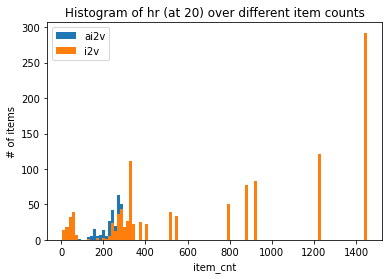

In [59]:
plt.hist(df_ai2v[df_ai2v[met_col_ai2v]==1]['item_cnt'], bins=100, label='ai2v')
plt.hist(df_i2v[df_i2v[met_col_i2v]==1]['item_cnt'], bins=100, label='i2v')
plt.xlabel('item_cnt')
plt.ylabel('# of items')
plt.title(f'Histogram of {metric} (at {k}) over different item counts')
plt.legend()
plt.show()

# TSNE

In [114]:
yahoo = pickle.load(open(f'{H_FOLD}/data/100_songs_train.pkl','rb'))

In [115]:
idx2item = pickle.load(pathlib.Path(f'{H_FOLD}/{DATA_FOLD}', 'idx2item.dat').open('rb'))

In [116]:
idx2item_dict = {i:k for i,k in enumerate(idx2item)}

In [117]:
itemid2singer = {yahoo[1][k]: k.split('#')[1] for k in yahoo[1].keys()}

In [119]:
idx2singer = {k: itemid2singer[int(idx2item_dict[k])] for k in list(idx2item_dict.keys())[:-2]}

In [130]:
colors = {singer:i for i,singer in enumerate(list(set(list(idx2singer.values()))))}

In [145]:
colors

{'Bob_Marley_&_The_Wailers': 0,
 'Toby_Keith': 1,
 'Metallica': 2,
 'Kenny_Chesney': 3,
 'Brad_Paisley': 4}

In [79]:
# Read MovieLens Movies
# datContent = [i.strip().split() for i in open(f'{H_FOLD}/data/movies.dat').readlines()]
# movs_jsons = []
# for mov_t in datContent:
#     mov = mov_t[:-1]
#     m_id, m_name_1 = mov[0].split('::')
#     tag = mov_t[-1]
#     t_id, t_name = tag.split('::')
#     movs_jsons.append({'id': m_id ,'name': m_name_1 + ' ' + ' '.join(mov[1:]), 'tag_id': t_id,  'tag name': t_name})

In [80]:
model = t.load(MODEL_FILE,map_location=t.device('cpu'))

In [81]:
X_embedded = TSNE(n_components=2).fit_transform(np.array(model.ai2v.tvectors.weight.data))

In [144]:
labels = np.array([colors[singer] for singer in idx2singer.values()])

No handles with labels found to put in legend.


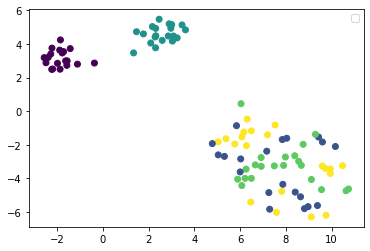

In [153]:
# fig, ax = plt.subplots()
# for clr in colors.values():
#     ix = np.where(labels==clr)
#     print(ix)
#     print(clr)
#     ax.scatter(X_embedded[ix,0], X_embedded[ix, 1], c = clr, s = 100)
# ax.legend()
# plt.show()

plt.scatter(X_embedded[:-2,0],X_embedded[:-2,1], c=[colors[singer] for singer in idx2singer.values()])
plt.legend()

# Popular Items Removal

In [4]:
k = 20
ic_file = f'{H_FOLD}/{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{H_FOLD}/{DATA_FOLD}/full_item2idx.dat'

In [5]:
item_cnts = pickle.load(open(ic_file, 'rb'))
itm_cnts_df = pd.DataFrame([item_cnts.keys(), item_cnts.values()]).T
itm_cnts_df.columns=['item_id','cnt']

In [6]:
# create hits file of popularity model

test_file = f'{H_FOLD}/{DATA_FOLD}/test_raw.csv'
test = pd.read_csv(test_file, names=['user','item'])
itms_pop_rank = [int(itm) for itm in itm_cnts_df.sort_values(by='cnt', ascending=False)['item_id'].tolist()[:k]]

hits = 0

test['pred_loc'] = 0
test['hit'] = test.apply(lambda row: 1 if row['item'] in itms_pop_rank else 0 , axis=1)
test.to_csv(f'{H_FOLD}/output/pop_model_hr_{k}.csv', index=False)

In [7]:
cnts_sorted = itm_cnts_df.sort_values(by=['cnt'],ascending=False)['cnt'].tolist()

In [8]:
items_sorted = [int(item) for item in itm_cnts_df.sort_values(by=['cnt'],ascending=False)['item_id'].tolist()[:-2]]

In [9]:
binned_items = [items_sorted[:i+10] for i in range(0, len(items_sorted), 10)]

In [10]:
binned_items.insert(0, [])

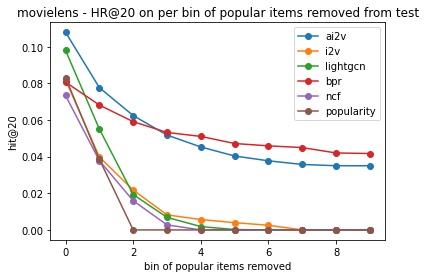

In [13]:
number_of_bins = 10
for hits_file, label in zip([f'{H_FOLD}/{AI2V_OUT_FOLD}/hr_{k}.csv', 
                             f'{H_FOLD}/{I2V_OUT_FOLD}/hr_{k}.csv', 
                             f'{H_FOLD}/{LGCN_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/{BPR_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/{NCF_OUT_FOLD}/hr_{k}.csv',
                             f'{H_FOLD}/output/pop_model_hr_{k}.csv'],
                            ['ai2v','i2v','lightgcn','bpr','ncf','popularity']):
    hits = pd.read_csv(hits_file, usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
    hit_ratios = []
    for bin_ in binned_items[:number_of_bins]:
        new_test = hits[~hits['item'].isin(bin_)]
        if not new_test.empty:
            hit_ratios.append(new_test[new_test['hit']==1].shape[0] / new_test.shape[0])
        else:
            hit_ratios.append(0)
    plt.plot([i for i in list(range(number_of_bins))], hit_ratios,'-o', label=label)
plt.xlabel('bin of popular items removed')
plt.ylabel(f'hit@{k}')
plt.title(f'{DATASET} - HR@{k} on per bin of popular items removed from test')
plt.legend()

# Statistics

In [96]:
def bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=False):
    item_cnts = pickle.load(open(ic_file, 'rb'))
    itm_cnts_df = pd.DataFrame([item_cnts.keys(), item_cnts.values()]).T
    itm_cnts_df.columns=['item_id','cnt']
    #itm_cnts_df.head(100)
    #print(len(itm_cnts_df))

    cnts_sorted = itm_cnts_df.sort_values(by=['cnt'],ascending=False)['cnt'].tolist()[:-2]
    #print(cnts_sorted)

    if amazon:
        items_sorted = [item for item in itm_cnts_df.sort_values(by=['cnt'],ascending=False)['item_id'].tolist()[:-2]]
        items_dict = {}
        counter = 0
        for item in items_sorted:
            if item not in items_dict.keys():
                items_dict[item] = counter
                counter += 1
        items_sorted = [items_dict[item] for item in items_sorted]
    else:
        items_sorted = [int(item) for item in itm_cnts_df.sort_values(by=['cnt'],ascending=False)['item_id'].tolist()[:-2]]
    
    items_cnt_dict = {}
    count = 0
    for item in range(len(items_sorted)):
        items_cnt_dict[items_sorted[item]] = cnts_sorted[item]
        count+=1
    #print(count)

    num_bins = 10
    bin_size = int(len(items_sorted)/num_bins)

    binned_items = [items_sorted[i*bin_size:(i+1)*bin_size] for i in range(0,num_bins-1)]
    last_bin = items_sorted[(num_bins-1)*bin_size:]
    binned_items.append(last_bin)

    #print(len(binned_items))
    count = 0
    for part in binned_items:
        count += len(part)
        #print(len(part))
    #print(count)
    #print(len(items_sorted))

    cnt_per_bin = []
    for part in binned_items:
        bin_cnt = []
        for item in part:
            bin_cnt.append(items_cnt_dict[item])
        cnt_per_bin.append(bin_cnt)
    
    fig1, ax1 = plt.subplots()
    ax1.set_title('Bins box plot')
    ax1.boxplot(cnt_per_bin)
    
    count = 1
    for binn in cnt_per_bin:
        # print("Bin num " + str(count))
        # print("The amount of items is " + str(len(binn)))
        # print("The bin mean " + str(mean(binn)))
        # print("The bin median " + str(median(binn)))
        # print("The bin max " + str(max(binn)))
        # print("The bin min " + str(min(binn)))
        # print()
        fig1, ax1 = plt.subplots()
        ax1.set_title('Bin box plot for bin number ' + str(count))
        ax1.boxplot(binn, vert=False, showmeans=True)
        count += 1
    
    max_amount = []
    for part in binned_items:
        max_amount.append(items_cnt_dict[part[0]])
    # print(max_amount)
    
    # plt.plot(max_amount)
    # plt.xlabel('bin of 10% items')
    # plt.ylabel(f'Amount')
    # plt.title(f'popular items')
    
    if amazon:
        return max_amount, items_sorted, items_dict
    else:
        return max_amount, items_sorted

In [97]:
def sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, items_sorted, items_dict={}):
    info = open(full_corpus, "r")
    connections_dict = {}
    amount_per_user = {}
    connections_list = []
    user_num = 0
    for line in info:
        line = line[:-1]
        line = line.split(" ")
        for item in line:
            if items_dict != {}:
                pair = [user_num, int(items_dict[item])]
                connections_list.append(pair)
                if user_num in connections_dict.keys():
                    connections_dict[user_num].append(int(items_dict[item]))
                else:
                    connections_dict[user_num] = [int(items_dict[item])]
            else:
                pair = [user_num, int(item)]
                connections_list.append(pair)
                if user_num in connections_dict.keys():
                    connections_dict[user_num].append(int(item))
                else:
                    connections_dict[user_num] = [int(item)]
        amount_per_user[user_num] = len(connections_dict[user_num])
        user_num += 1
        #if user_num > 500:
        #    break
    # Calling DataFrame constructor on list  
    dframe = pd.DataFrame(connections_list, columns=['user', 'item'])  
    #print(dframe)

    sorted_user_amount = sorted(amount_per_user.items(), key=lambda kv: kv[1], reverse=True)
    x, y = zip(*sorted_user_amount) # unpack a list of pairs into two tuples
    plt.plot(y)
    plt.xlabel('Users')
    plt.ylabel(f'Amount of items')
    plt.title(f'Amount of items per user')
    

    num_conections = len(connections_list)
    possible_connections = user_num * len(items_sorted)
    spars = float(num_conections)/float(possible_connections)
    spars = spars*100
    print("Percentage of sparse is " + str(spars))

In [98]:
def bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=False, precent=False):
    item_cnts = pickle.load(open(ic_file, 'rb'))
    itm_cnts_df = pd.DataFrame([item_cnts.keys(), item_cnts.values()]).T
    itm_cnts_df.columns=['item_id','cnt']
    #itm_cnts_df.head(100)
    #print(len(itm_cnts_df))

    cnts_sorted = itm_cnts_df.sort_values(by=['cnt'],ascending=False)['cnt'].tolist()[:-2]
    #print(cnts_sorted)

    if amazon:
        items_sorted = [item for item in itm_cnts_df.sort_values(by=['cnt'],ascending=False)['item_id'].tolist()[:-2]]
        items_dict = {}
        counter = 0
        for item in items_sorted:
            if item not in items_dict.keys():
                items_dict[item] = counter
                counter += 1
        items_sorted = [items_dict[item] for item in items_sorted]
    else:
        items_sorted = [int(item) for item in itm_cnts_df.sort_values(by=['cnt'],ascending=False)['item_id'].tolist()[:-2]]
    
    items_cnt_dict = {}
    count = 0
    samples_amount = 0
    for item in range(len(items_sorted)):
        items_cnt_dict[items_sorted[item]] = cnts_sorted[item]
        samples_amount += cnts_sorted[item]
        count+=1
    # print(count)
    # print(samples_amount)

    num_bins = 100
    bin_size = int(len(items_sorted)/num_bins)

    binned_items = [items_sorted[i*bin_size:(i+1)*bin_size] for i in range(0,num_bins-1)]
    last_bin = items_sorted[(num_bins-1)*bin_size:]
    binned_items.append(last_bin)

    #print(len(binned_items))
    count = 0
    for part in binned_items:
        count += len(part)
        #print(len(part))
    #print(count)
    #print(len(items_sorted))

    cnt_per_bin = []
    for part in binned_items:
        bin_cnt = []
        for item in part:
            bin_cnt.append(items_cnt_dict[item])
        cnt_per_bin.append(bin_cnt)
    
    if precent == True:
        max_amount = []
        for part in binned_items:
            calc = (items_cnt_dict[part[0]]/samples_amount)*100
            max_amount.append(calc)
    
        return max_amount
    else:
        max_amount = []
        for part in binned_items:
            max_amount.append(items_cnt_dict[part[0]])

        return max_amount

In [99]:
datasets_bins = []
datasets_bins_precent = []
labels = []

### MovieLens

In [100]:
DATASET = 'movielens'
DATA_FOLD = f'corpus/{DATASET}_llo'
AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
ic_file = f'{DATA_FOLD}/full_ic.dat'
full_corpus = f'{DATA_FOLD}/full_corpus.txt'

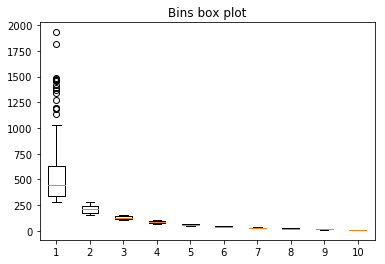

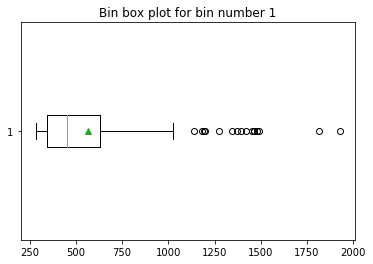

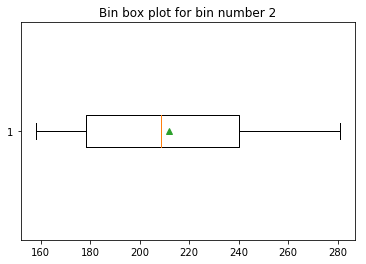

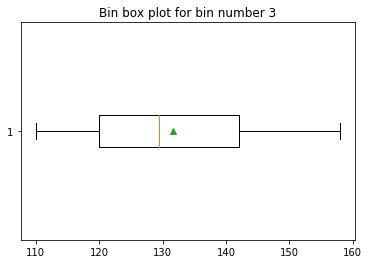

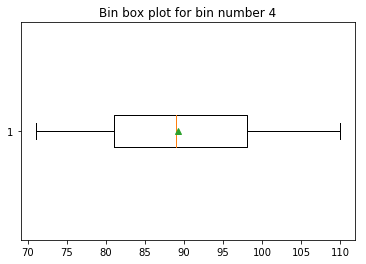

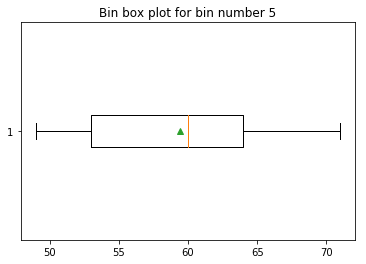

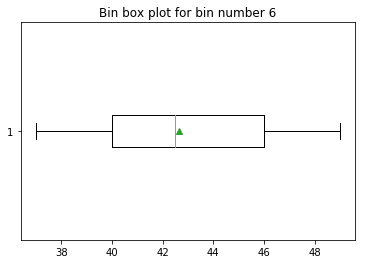

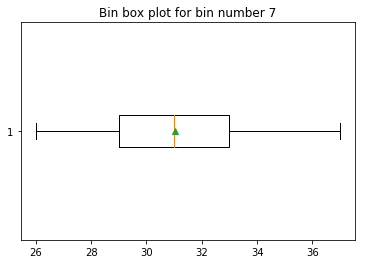

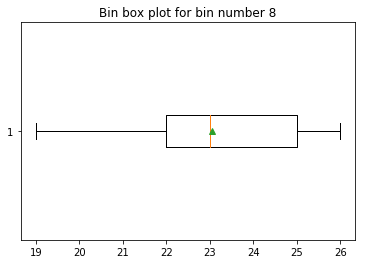

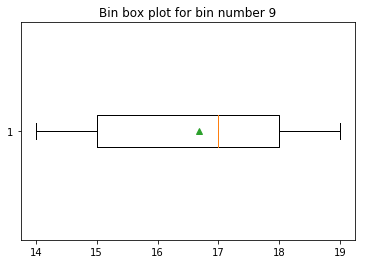

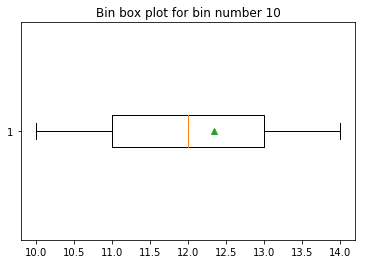

In [101]:
movielens_10bins, movielens_items_sorted = bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)

Percentage of sparse is 2.0490758459689027


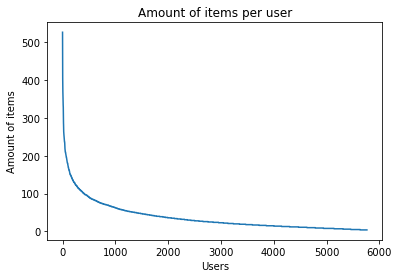

In [102]:
sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, movielens_items_sorted)

In [103]:
movielens_100bins = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)
movielens_100bins_precent = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, precent=True)
datasets_bins.append(movielens_100bins)
datasets_bins_precent.append(movielens_100bins_precent)
labels.append(DATASET)

### Moviesdat

In [104]:
DATASET = 'moviesdat'
DATA_FOLD = f'corpus/{DATASET}_llo'
AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
ic_file = f'{DATA_FOLD}/full_ic.dat'
full_corpus = f'{DATA_FOLD}/full_corpus.txt'

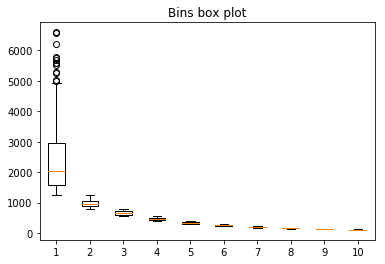

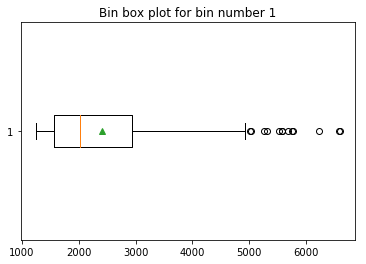

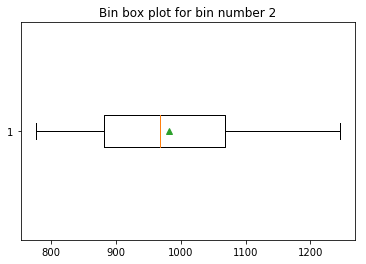

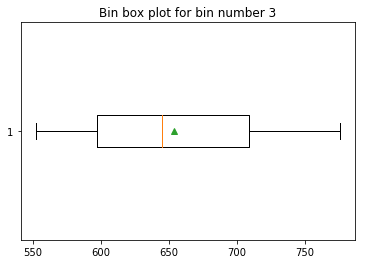

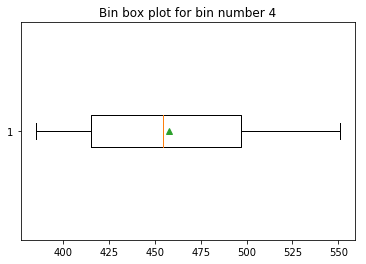

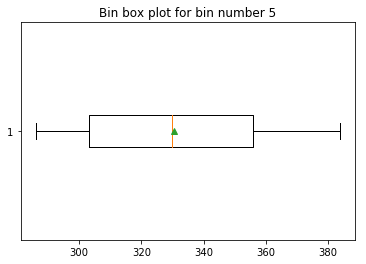

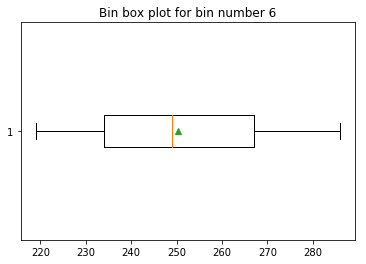

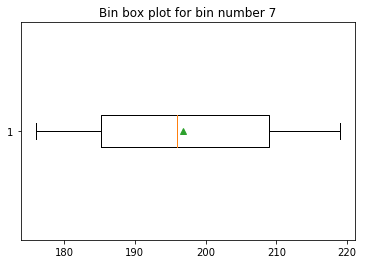

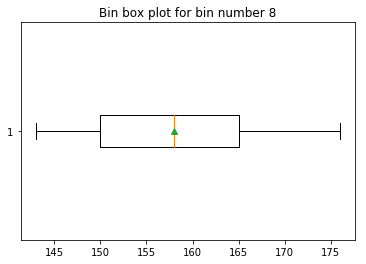

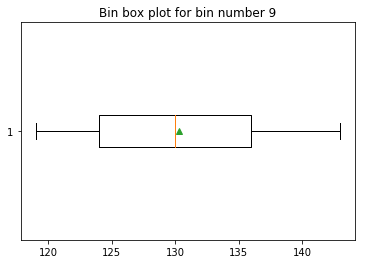

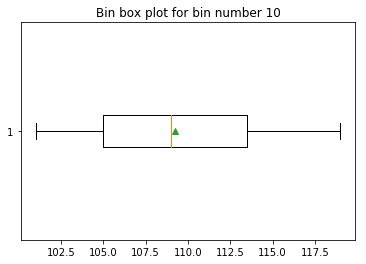

In [105]:
moviesdat_10bins, moviesdat_items_sorted = bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)

Percentage of sparse is 5.0834813501274185


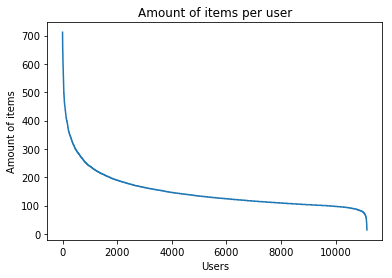

In [106]:
sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, moviesdat_items_sorted)

In [107]:
moviesdat_100bins = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)
moviesdat_100bins_precent = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, precent=True)
datasets_bins.append(moviesdat_100bins)
datasets_bins_precent.append(moviesdat_100bins_precent)
labels.append(DATASET)

### Netflix

In [108]:
DATASET = 'netflix'
DATA_FOLD = f'corpus/{DATASET}_llo'
AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
ic_file = f'{DATA_FOLD}/full_ic.dat'
full_corpus = f'{DATA_FOLD}/full_corpus.txt'

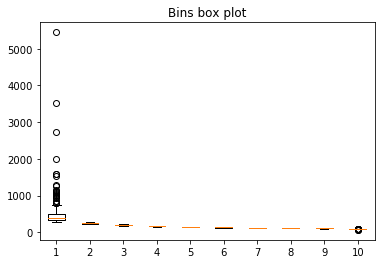

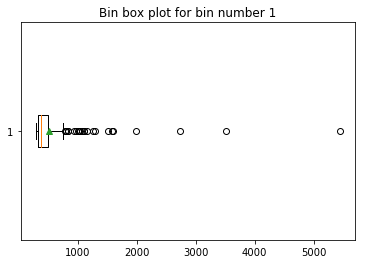

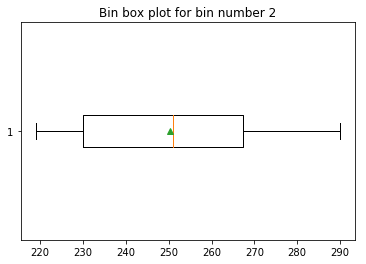

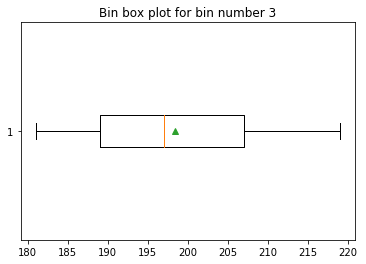

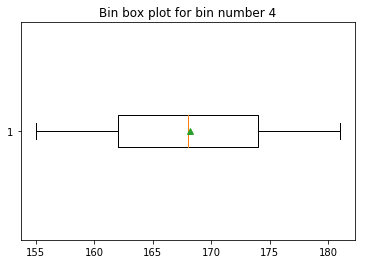

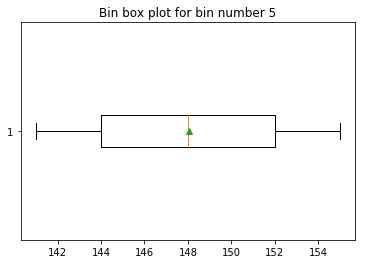

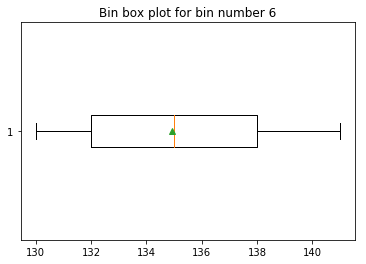

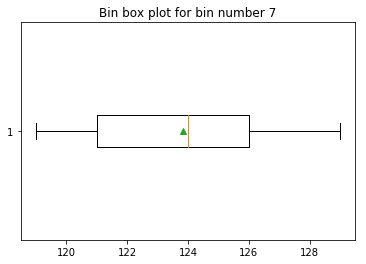

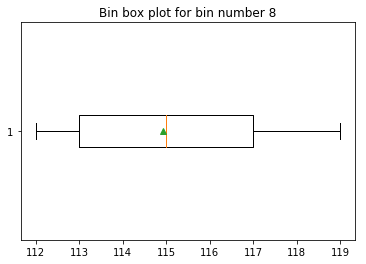

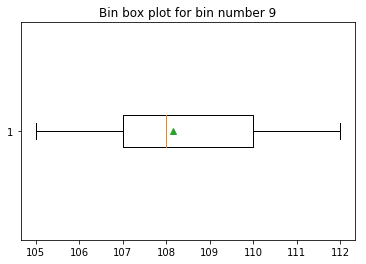

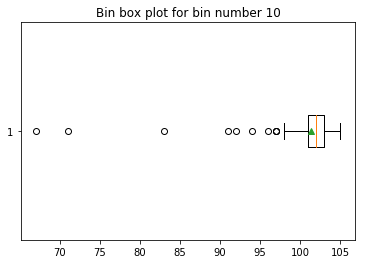

In [109]:
netflix_10bins, netflix_items_sorted = bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)

Percentage of sparse is 1.750054987837322


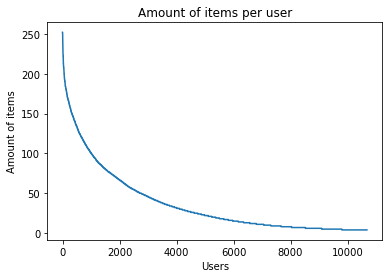

In [110]:
sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, netflix_items_sorted)

In [111]:
netflix_100bins = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)
netflix_100bins_precent = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, precent=True)
datasets_bins.append(netflix_100bins)
datasets_bins_precent.append(netflix_100bins_precent)
labels.append(DATASET)

### Yahoo

In [112]:
DATASET = 'yahoo'
DATA_FOLD = f'corpus/{DATASET}_llo'
AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
ic_file = f'{DATA_FOLD}/full_ic.dat'
full_corpus = f'{DATA_FOLD}/full_corpus.txt'

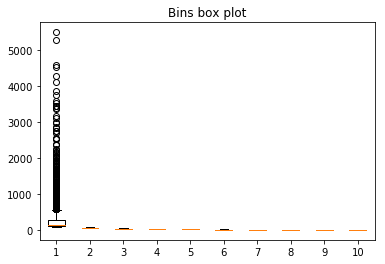

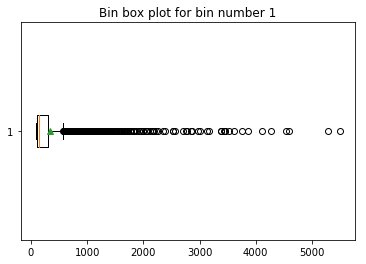

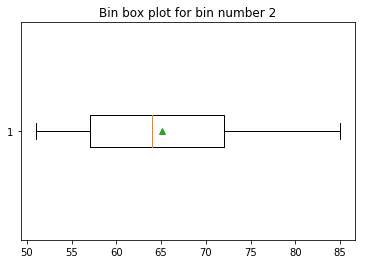

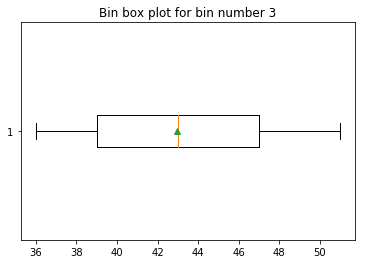

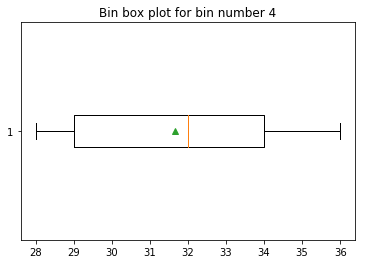

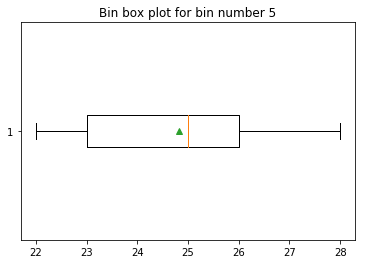

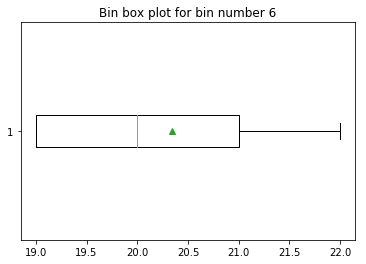

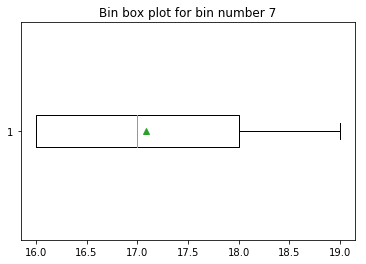

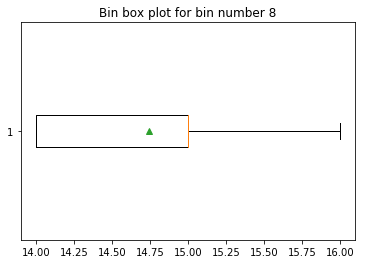

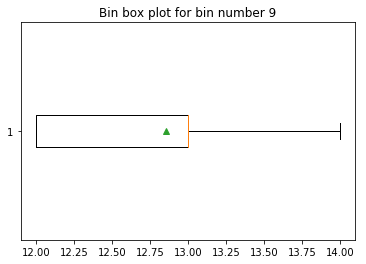

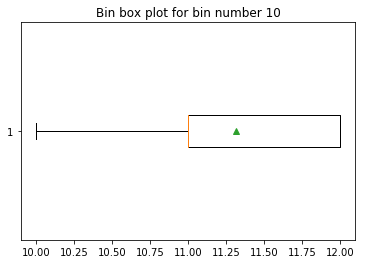

In [113]:
yahoo_10bins, yahoo_items_sorted = bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)

Percentage of sparse is 0.30559488441415616


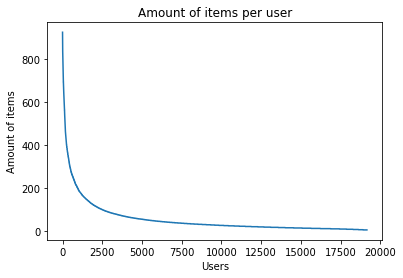

In [114]:
sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, yahoo_items_sorted)

In [115]:
yahoo_100bins = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)
yahoo_100bins_precent = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, precent=True)
datasets_bins.append(yahoo_100bins)
datasets_bins_precent.append(yahoo_100bins_precent)
labels.append(DATASET)

### AmazonBeauty

In [116]:
DATASET = 'amazonbeauty'
DATA_FOLD = f'corpus/{DATASET}_llo'
AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
ic_file = f'{DATA_FOLD}/full_ic.dat'
full_corpus = f'{DATA_FOLD}/full_corpus.txt'

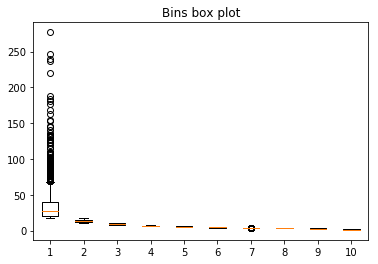

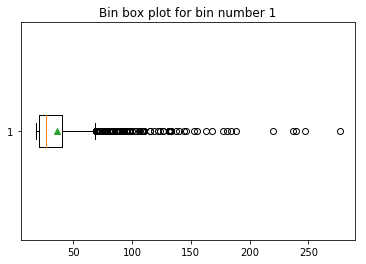

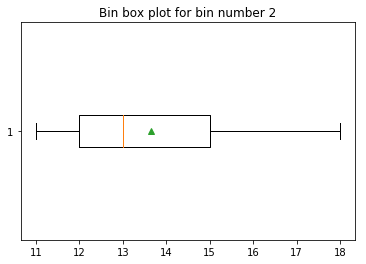

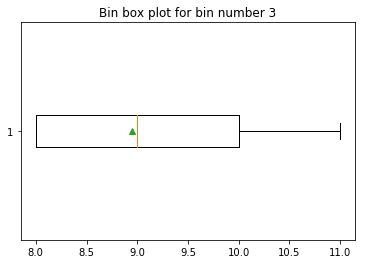

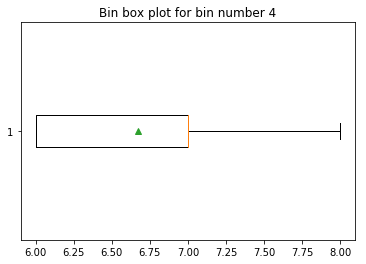

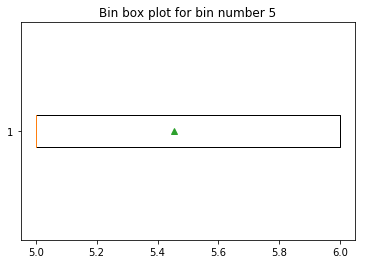

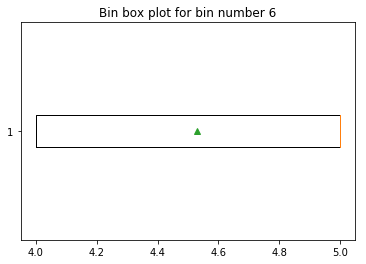

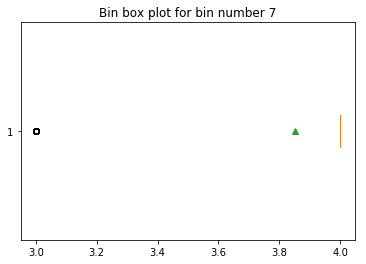

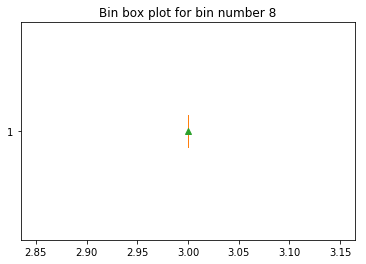

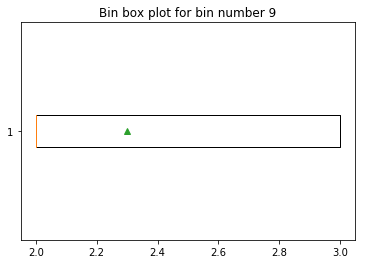

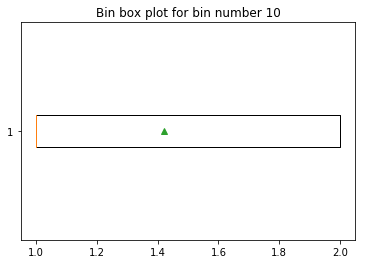

In [117]:
amazonbeauty_10bins, amazonbeauty_items_sorted, amazonbeauty_items_dict = bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=True)

Percentage of sparse is 0.04735977717822697


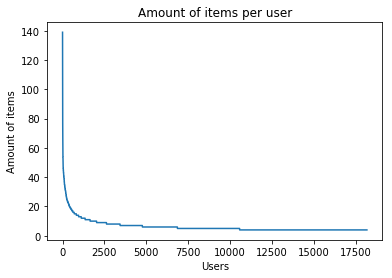

In [118]:
sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazonbeauty_items_sorted)

In [119]:
amazonbeauty_100bins = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=True)
amazonbeauty_100bins_precent = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=True, precent=True)
datasets_bins.append(amazonbeauty_100bins)
datasets_bins_precent.append(amazonbeauty_100bins_precent)
labels.append(DATASET)

### GoodBooks

In [120]:
DATASET = 'goodbooks'
DATA_FOLD = f'corpus/{DATASET}_llo'
AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
ic_file = f'{DATA_FOLD}/full_ic.dat'
full_corpus = f'{DATA_FOLD}/full_corpus.txt'

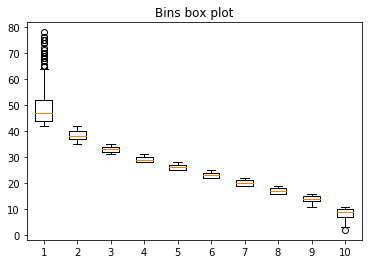

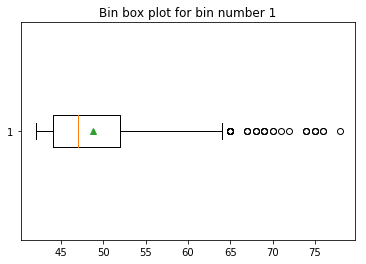

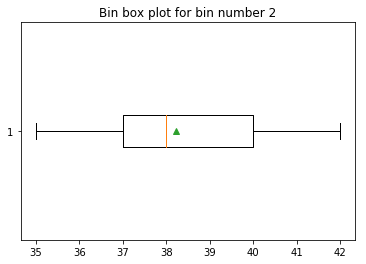

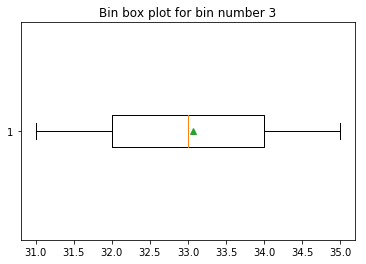

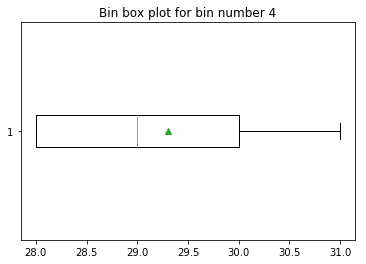

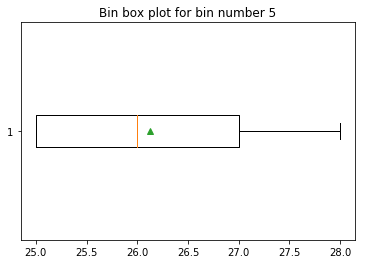

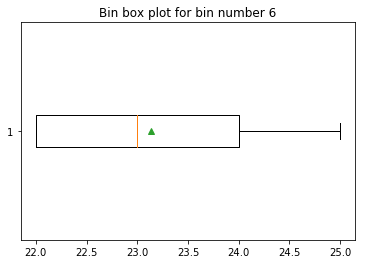

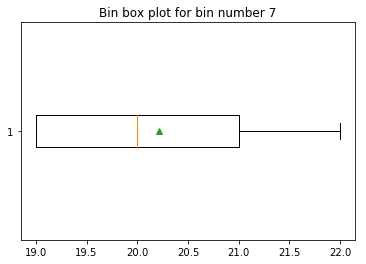

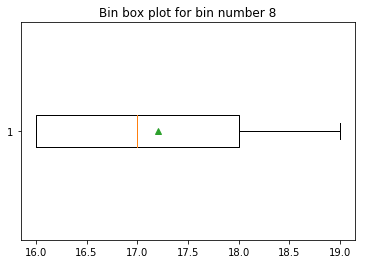

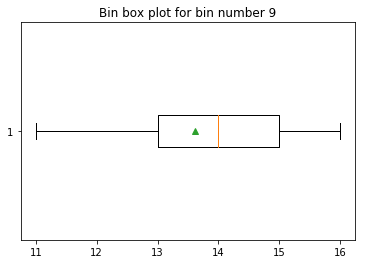

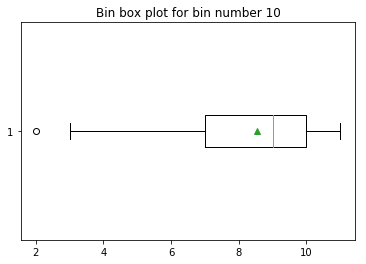

In [121]:
goodbooks_10bins, goodbooks_items_sorted = bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)

Percentage of sparse is 0.13847627586136682


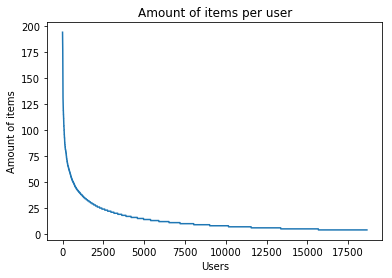

In [122]:
sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, goodbooks_items_sorted)

In [123]:
goodbooks_100bins = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus)
goodbooks_100bins_precent = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, precent=True)
datasets_bins.append(goodbooks_100bins)
datasets_bins_precent.append(goodbooks_100bins_precent)
labels.append(DATASET)

### AmazonBooks

In [124]:
DATASET = 'amazonbooks'
DATA_FOLD = f'corpus/{DATASET}_llo'
AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo'
ic_file = f'{DATA_FOLD}/full_ic.dat'
full_corpus = f'{DATA_FOLD}/full_corpus.txt'

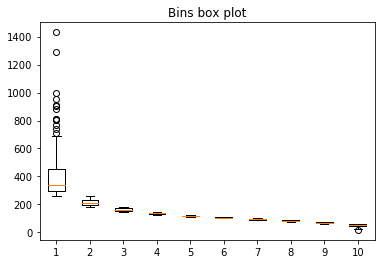

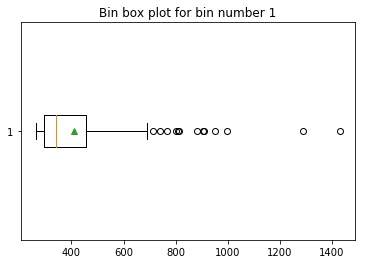

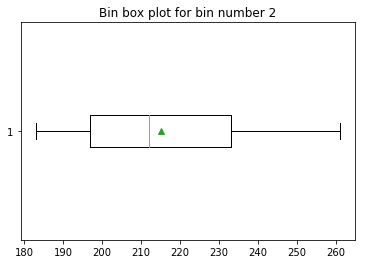

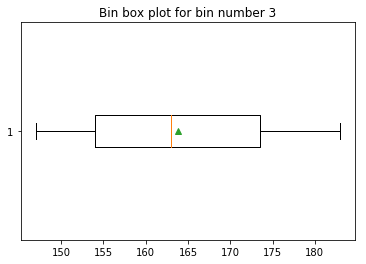

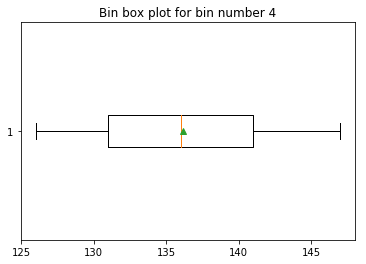

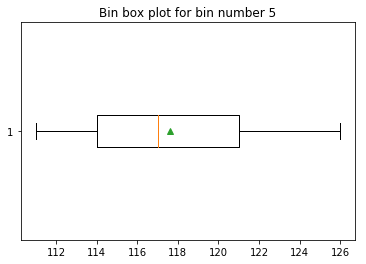

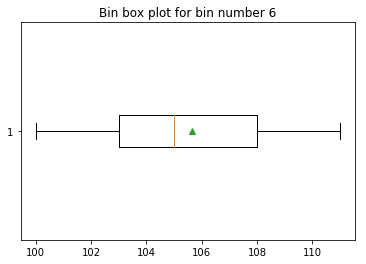

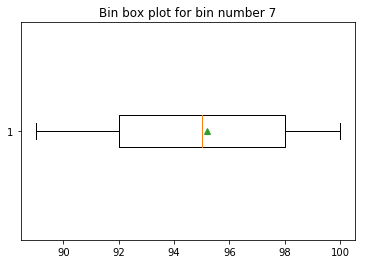

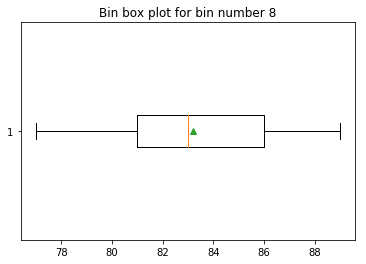

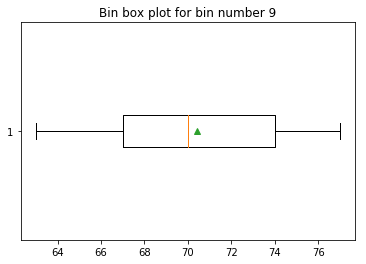

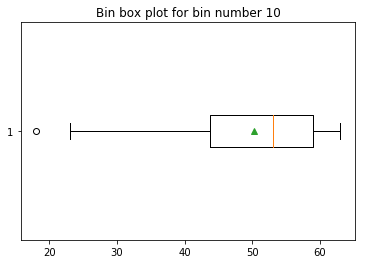

In [125]:
amazonbooks_10bins, amazonbooks_items_sorted, amazonbooks_items_dict = bin_maker(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=True)

Percentage of sparse is 0.46328820945808386


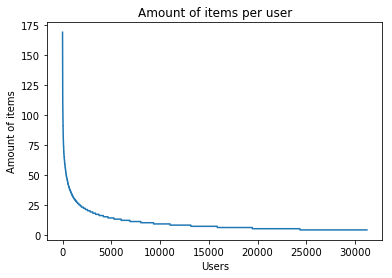

In [126]:
sparce(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazonbooks_items_sorted, amazonbooks_items_dict)

In [127]:
amazonbooks_100bins = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=True)
amazonbooks_100bins_precent = bin_maker_100(DATASET, DATA_FOLD, AI2V_OUT_FOLD, ic_file, full_corpus, amazon=True, precent=True)
datasets_bins.append(amazonbooks_100bins)
datasets_bins_precent.append(amazonbooks_100bins_precent)
labels.append(DATASET)

### All

In [ ]:
# You could either normalize to the range between 0 and 1, norm = lambda x: (x-x.min())/(x.max()-x.min())
# or to the range around the mean, norm = lambda x: 2*(x-x.mean())/(x.max()-x.min())

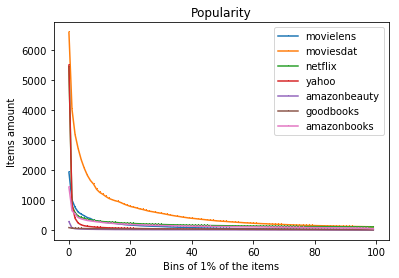

In [128]:
number_of_bins = 100
for data in range(len(datasets_bins)):
    plt.plot([i for i in list(range(number_of_bins))], datasets_bins[data], '-o', label=labels[data], marker=",")
plt.xlabel('Bins of 1% of the items')
plt.ylabel('Items amount')
plt.title('Popularity')
plt.legend()

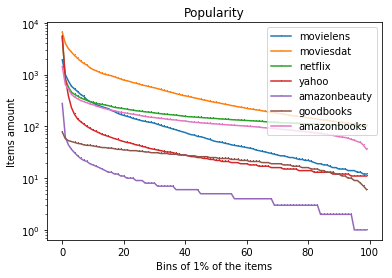

In [129]:
number_of_bins = 100
for data in range(len(datasets_bins)):
    plt.plot([i for i in list(range(number_of_bins))], datasets_bins[data], '-o', label=labels[data], marker=",")
plt.xlabel('Bins of 1% of the items')
plt.ylabel('Items amount')
plt.yscale('log')
plt.title('Popularity')
plt.legend()

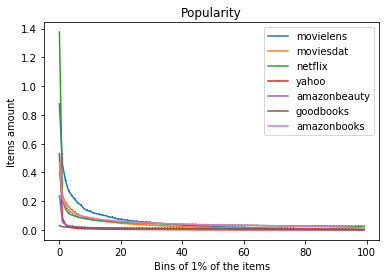

In [130]:
number_of_bins = 100
for data in range(len(datasets_bins_precent)):
    plt.plot([i for i in list(range(number_of_bins))], datasets_bins_precent[data], '-o', label=labels[data], marker=",")
plt.xlabel('Bins of 1% of the items')
plt.ylabel('Items amount')
plt.title('Popularity')
plt.legend()

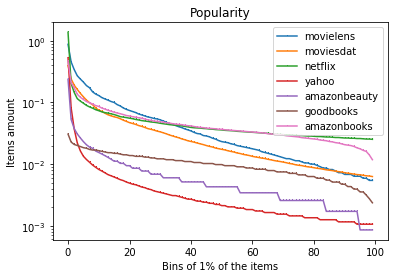

In [131]:
number_of_bins = 100
for data in range(len(datasets_bins_precent)):
    plt.plot([i for i in list(range(number_of_bins))], datasets_bins_precent[data], '-o', label=labels[data], marker=",")
plt.xlabel('Bins of 1% of the items')
plt.ylabel('Items amount')
plt.yscale('log')
plt.title('Popularity')
plt.legend()

# Attention Scores

### MovieLens

In [ ]:
DATASET = 'movielens'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
# from dat to csv:
file_out = './corpus/movielens_llo/movies.csv'
with open(file_out, 'w', newline='', encoding="utf-8") as w_file:
    writer = csv.writer(w_file, delimiter=',', quotechar='"', escapechar='\n', quoting=csv.QUOTE_NONE)
    writer.writerow(['id', 'name', 'genres'])
    with open(f'{DATA_FOLD}/movies.dat', encoding='ISO-8859-1') as data:
        for line in data:
            line = line.split('::')
            item_idx = line[0]
            item_name = line[1]
            item_genres = line[2]
            writer.writerow([str(item_idx), str(item_name), str(item_genres)])

test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/movies.csv')
movies_test = []
print(movies)
for tup in test_orig:
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 53
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()

sample = 5
# For the movie "Pretty Woman" the movie that received the higher score is "my Fair Lady". Both movies describes the journey that the woman goes through from the streets to a lady accepted by society. Both movies are known and successful romances.

sample = 19
# For the movie "The Fifth Element" the movie that received the higher score is "Matrix". Both movies are science fiction movies. The rest of the movies on the list are dramas and so "Matrix" is the best fit for "The Fifth Element".

sample = 31
# For the movie "The Green Mile" the movie that received the higher score is "Twelve Monkeys". "The Green Mile" is a fantasy drama movie and "Twelve Monkeys" is a science fiction drama movie. In both movies, there is an engagement with a disease.

sample = 45
# For the movie "Evil Dead 2" the movie that received the higher score is "I Still Know What You Did Last Summer". Both movies are horror movies and sequels. Most of the movies on this list are horror movies when evil dead 2 is a horror-comedy.

sample = 49

sample = 82
# For the movie "Bone Collector" the movie that received the higher score is "The Exorcist". "Bone Collector" is a thriller and "The Exorcist" is a horror movie and those are two genres that have a lot of similarities. The second best movie is "Final Destination" which is also a horror movie.

In [ ]:
# Not working right, show the same scores every time.
data = np.expand_dims(attention_score[0], axis=1)
labels = movies_test[0][0]
target = movies_test[15][1]
cmap = plt.cm.gray
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))
fig, ax = plt.subplots(figsize=(2, 10))
ax.imshow(rgba, interpolation='nearest')
im = ax.imshow(data, visible=False, cmap=cmap)
ax.set_yticks(list(range(data.shape[0])))
ax.set_yticklabels(labels)
fig.colorbar(im)
plt.title(f'Attention scores for {target}')

### GoodBooks

In [ ]:
DATASET = 'goodbooks'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/books_job.csv', encoding='latin-1')
movies_test = []
for tup in test_orig:
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 0
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()

sample = 46

sample = 70

sample = 97

sample = 98

### Netflix

In [ ]:
DATASET = 'netflix'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
# Theres a problem, it's not working.
test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/movie_titles.csv', encoding='latin-1')
movies_test = []
print(movies)
for tup in test_orig:
    print(movies.loc[movies['id']==tup[1],'name'])
    print(tup[1])
    print(tup)
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 0
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()

### Moviesdat

In [ ]:
DATASET = 'moviesdat'

DATA_FOLD = f'corpus/{DATASET}_llo' #######################

AI2V_OUT_FOLD = f'output/{DATASET}_ai2v_llo' ########################

AI2V_MODEL_FILE = f'{H_FOLD}/{AI2V_OUT_FOLD}/model.pt'

k = 20 #############################
ic_file = f'{DATA_FOLD}/full_ic.dat'
item2idx_file = f'{DATA_FOLD}/full_item2idx.dat'

hits_ai2v = pd.read_csv(f'{AI2V_OUT_FOLD}/hr_{k}.csv', usecols=[0,1,2,3], skiprows=1, names=['user','item','pred_loc','hit'])
hits_ai2v[hits_ai2v['hit']==1].head(100)

In [ ]:
# Theres a problem, it's not working.
test_data = pickle.load(open(f'{DATA_FOLD}/test.dat','rb'))
item2idx = pickle.load(open(f'{DATA_FOLD}/item2idx.dat','rb'))
idx2item = {v:k for k,v in item2idx.items()}
test_orig = []
for tup in test_data:
    target = int(idx2item[tup[1]])
    context = [int(idx2item[idx]) for idx in tup[0]]
    test_orig.append((context, target))
movies = pd.read_csv(f'{DATA_FOLD}/movies_job.csv', encoding='latin-1')
movies_test = []
print(movies)
for tup in test_orig:
    print(movies.loc[movies['id']==tup[1],'name'])
    print(tup[1])
    target = movies.loc[movies['id']==tup[1],'name'].values[0]
    context = [movies.loc[movies['id']==idx,'name'].values[0] 
              for idx in tup[0]]
    movies_test.append((context, target))

In [ ]:
attention_score = pickle.load(open(f'{AI2V_OUT_FOLD}/attention_scores.pkl','rb'))

lists = []
for idx in range(len(attention_score[:100])):
    if len(attention_score[idx]) <= 20:
        lists.append(idx)
print(lists)

In [ ]:
sample = 0
data = np.expand_dims(attention_score[sample], axis=0)
labels = movies_test[sample][0]
target = movies_test[sample][1]


cmap = plt.cm.summer
norm = plt.Normalize(data.min(), data.max())
rgba = cmap(norm(data))

fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(rgba, interpolation='nearest')

im = ax.imshow(data, visible=False, cmap=cmap)

ax.set_xticks(list(range(data.shape[1])))

ax.set_xticklabels(labels, rotation = 90)

for i in range(data.shape[1]):
    text = ax.text(i, 0, round(data[0, i],3),
                       ha="center", va="center")

fig.colorbar(im)
plt.title(f'Attention scores for {target}')
plt.show()